
# Visualize the hemodynamic response

In this example, we describe how the hemodynamic response function was
estimated in the previous model. We fit the same ridge model as in the previous
example, and further describe the need to delay the features in time to account
for the delayed BOLD response.

Because of the temporal dynamics of neurovascular coupling, the recorded BOLD
signal is delayed in time with respect to the stimulus. To account for this
lag, we fit encoding models on delayed features. In this way, the linear
regression model weighs each delayed feature separately and recovers the shape
of the hemodynamic response function in each voxel separately. In turn, this
method (also known as a Finite Impulse Response model, or FIR) maximizes the
model prediction accuracy. With a repetition time of 2 seconds, we typically
use 4 delays [1, 2, 3, 4] to cover the peak of the the hemodynamic response
function. However, the optimal number of delays can vary depending on the
experiment and the brain area of interest, so you should experiment with
different delays.

In this example, we show that a model without delays performs far worse than a
model with delays. We also show how to visualize the estimated hemodynamic
response function (HRF) from a model with delays.


## Path of the data directory



In [1]:
from fmri.features import load_brain_data, load_feature

directory = '../../data'
print(directory)

../../data


In [2]:
# modify to use another subject
subject = 1

## Load the data

We first load the fMRI responses.



In [3]:

import numpy as np

Y, n_samples_train, _ = load_brain_data(directory, subject, "reading")
Y_train = Y[:n_samples_train]
Y_test = Y[n_samples_train:]

print("(n_samples_train, n_voxels) =", Y_train.shape)
print("(n_repeats, n_samples_test, n_voxels) =", Y_test.shape)

/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/features.py:29: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  story_data = zscore(story_data)
/home/leo/PycharmProjects/compare_variance_residual/compare_variance_residual/fmri/featu

(n_samples_train, n_voxels) = (3737, 81133)
(n_repeats, n_samples_test, n_voxels) = (291, 81133)


We average the test repeats, to remove the non-repeatable part of fMRI
responses.



In [4]:
# Y_test = Y_test.mean(0)

print("(n_samples_test, n_voxels) =", Y_test.shape)

(n_samples_test, n_voxels) = (291, 81133)


We fill potential NaN (not-a-number) values with zeros.



In [5]:
Y_train = np.nan_to_num(Y_train)
Y_test = np.nan_to_num(Y_test)

Then, we load the semantic "wordnet" features.



In [6]:
feature_space = "english1000"

X, n_samples_train = load_feature(directory, feature_space)
X_train = X[:n_samples_train]
X_test = X[n_samples_train:]

print("(n_samples_train, n_features) =", X_train.shape)
print("(n_samples_test, n_features) =", X_test.shape)

(n_samples_train, n_features) = (3737, 985)
(n_samples_test, n_features) = (291, 985)


## Define the cross-validation scheme


We define a cross-validation splitter, compatible with ``scikit-learn`` API.



In [7]:
cv = 5

## Define the model

We define the same model as in the previous example. See the previous
example for more details about the model definition.



In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from voxelwise_tutorials.delayer import Delayer
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.ridge import RidgeCV
from himalaya.backend import set_backend

backend = set_backend("torch_cuda", on_error="warn")

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

alphas = np.logspace(1, 20, 20)

pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=[1, 2, 3, 4]),
    RidgeCV(alphas=alphas, cv=cv,
            solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                               n_targets_batch_refit=100)),
)

In [9]:
from sklearn import set_config

set_config(display='diagram')  # requires scikit-learn 0.23
pipeline

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('delayer', Delayer(delays=[1, 2, 3, 4])),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                         solver_params={'n_alphas_batch': 5,
                                        'n_targets_batch': 500,
                                        'n_targets_batch_refit': 100}))])

## Fit the model

We fit on the train set, and score on the test set.



In [10]:
pipeline.fit(X_train, Y_train)

scores = pipeline.score(X_test, Y_test)
scores = backend.to_numpy(scores)
print("(n_voxels,) =", scores.shape)

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/himalaya/ridge/_random_search.py:491: UserWarning: Solving ridge is slower than solving kernel ridge when n_samples < n_features (here 3737 < 3940). Using a linear kernel in himalaya.kernel_ridge.KernelRidgeCV or himalaya.kernel_ridge.solve_kernel_ridge_cv_eigenvalues would be faster. Use warn=False to silence this warning.
  warnings.warn(


(n_voxels,) = (81133,)


## Intermission: understanding delays

To have an intuitive understanding of what we accomplish by delaying the
features before model fitting, we will simulate one voxel and a single
feature. We will then create a ``Delayer`` object (which was used in the
previous pipeline) and visualize its effect on our single feature. Let's
start by simulating the data.



In [11]:
# number of total trs
n_trs = 50
# repetition time for the simulated data
TR = 2.0
rng = np.random.RandomState(42)
y = rng.randn(n_trs)
x = np.zeros(n_trs)
# add some arbitrary value to our feature
x[15:20] = .5
x += rng.randn(n_trs) * 0.1  # add some noise

# create a delayer object and delay the features
delayer = Delayer(delays=[0, 1, 2, 3, 4])
x_delayed = delayer.fit_transform(x[:, None])

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In the next cell we are plotting six lines. The subplot at the top shows the
simulated BOLD response, while the other subplots show the simulated feature
at different delays. The effect of the delayer is clear: it creates multiple
copies of the original feature shifted forward in time by how many samples we
requested (in this case, from 0 to 4 samples, which correspond to 0, 2, 4, 6,
and 8 s in time with a 2 s TR).

When these delayed features are used to fit a voxelwise encoding model, the
brain response $y$ at time $t$ is simultaneously modeled by the
feature $x$ at times $t-0, t-2, t-4, t-6, t-8$. In the remaining
of this example we will see that this method improves model prediction
accuracy and it allows to account for the underlying shape of the hemodynamic
response function.



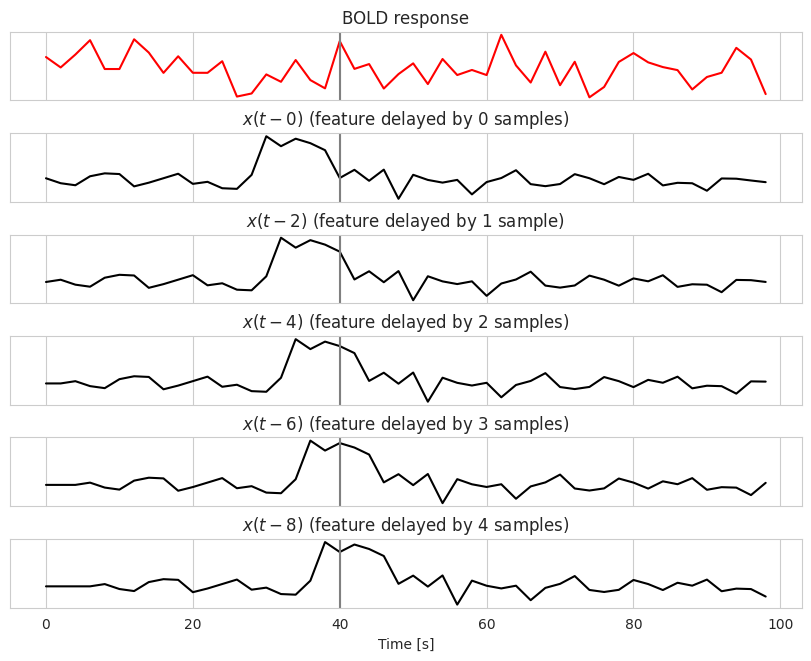

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6, 1, figsize=(8, 6.5), constrained_layout=True,
                        sharex=True)
times = np.arange(n_trs) * TR

axs[0].plot(times, y, color="r")
axs[0].set_title("BOLD response")
for i, (ax, xx) in enumerate(zip(axs.flat[1:], x_delayed.T)):
    ax.plot(times, xx, color='k')
    ax.set_title("$x(t - {0:.0f})$ (feature delayed by {1} sample{2})".format(
        i * TR, i, "" if i == 1 else "s"))
for ax in axs.flat:
    ax.axvline(40, color='gray')
    ax.set_yticks([])
_ = axs[-1].set_xlabel("Time [s]")
plt.show()

## Compare with a model without delays

We define here another model without feature delays (i.e. no ``Delayer``).
Because the BOLD signal is inherently slow due to the dynamics of
neuro-vascular coupling, this model is unlikely to perform well.

Note that if we remove the feature delays, we will have more fMRI samples
(3600) than number of features (1705). In this case, running a kernel version
of ridge regression is computationally suboptimal. Thus, to create a model
without delays we are using `RidgeCV` instead of `KernelRidgeCV`.



In [13]:
pipeline_no_delay = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    RidgeCV(
        alphas=alphas, cv=cv, solver="svd",
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)
pipeline_no_delay

Pipeline(steps=[('standardscaler', StandardScaler(with_std=False)),
                ('ridgecv',
                 RidgeCV(alphas=array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11, 1.e+12, 1.e+13, 1.e+14, 1.e+15, 1.e+16,
       1.e+17, 1.e+18, 1.e+19, 1.e+20]),
                         solver_params={'n_alphas_batch': 5,
                                        'n_targets_batch': 500,
                                        'n_targets_batch_refit': 100}))])

We fit and score the model as the previous one.



In [14]:
pipeline_no_delay.fit(X_train, Y_train)
scores_no_delay = pipeline_no_delay.score(X_test, Y_test)
scores_no_delay = backend.to_numpy(scores_no_delay)
print("(n_voxels,) =", scores_no_delay.shape)

(n_voxels,) = (81133,)


Then, we plot the comparison of model prediction accuracies with a 2D
histogram. All ~70k voxels are represented in this histogram, where the
diagonal corresponds to identical prediction accuracy for both models. A
distibution deviating from the diagonal means that one model has better
prediction accuracy than the other.



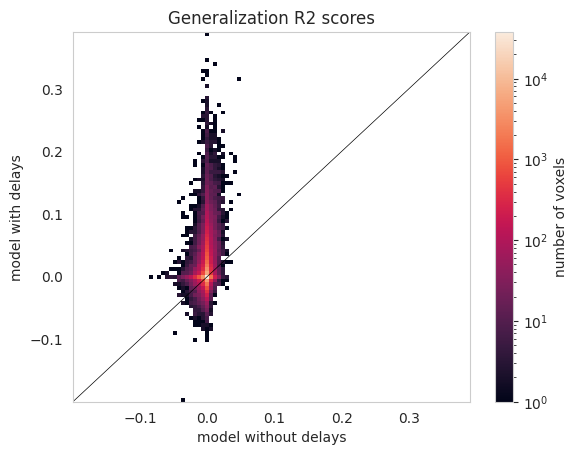

In [15]:
from voxelwise_tutorials.viz import plot_hist2d

ax = plot_hist2d(scores_no_delay, scores)
ax.set(
    title='Generalization R2 scores',
    xlabel='model without delays',
    ylabel='model with delays',
)
plt.show()

We see that the model with delays performs much better than the model without
delays. This can be seen in voxels with scores above 0. The distribution
of scores below zero is not very informative, since it corresponds to voxels
with poor predictive performance anyway, and it only shows which model is
overfitting the most.



## Visualize the HRF

We just saw that delays are necessary to model BOLD responses. Here we show
how the fitted ridge regression weights follow the hemodynamic response
function (HRF).

Fitting a kernel ridge regression results in a set of coefficients called the
"dual" coefficients $w$. These coefficients differ from the "primal"
coefficients $\beta$ obtained with a ridge regression, but the primal
coefficients can be computed from the dual coefficients using the training
features $X$:

\begin{align}\beta = X^\top w\end{align}

To better visualize the HRF, we will refit a model with more delays, but only
on a selection of voxels to speed up the computations.



In [17]:
import seaborn as sns
import simplstyles
plt.style.use('nord-light-talk')

/home/leo/PycharmProjects/compare_variance_residual/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


(n_delays, n_features, n_voxels) = (10, 985, 100)


/tmp/ipykernel_21824/1537985436.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


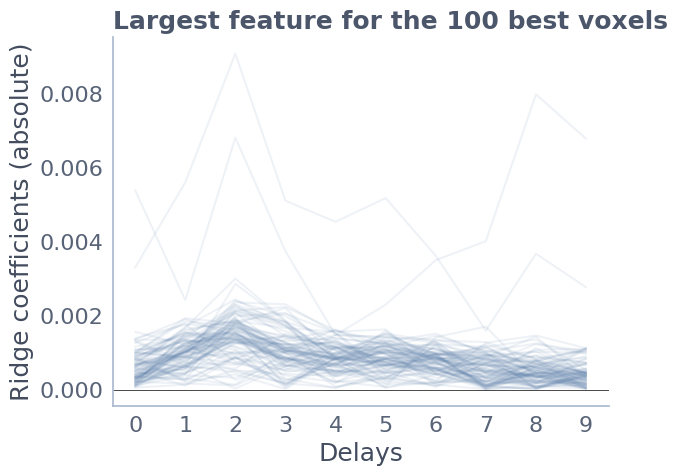

In [33]:
# pick the 10 best voxels
voxel_selection = np.argsort(scores)[-100:]

# define a pipeline with more delays
pipeline_more_delays = make_pipeline(
    StandardScaler(with_mean=True, with_std=False),
    Delayer(delays=range(10)),
    KernelRidgeCV(
        alphas=alphas, cv=cv,
        solver_params=dict(n_targets_batch=500, n_alphas_batch=5,
                           n_targets_batch_refit=100)),
)

pipeline_more_delays.fit(X_train, Y_train[:, voxel_selection])

# get the (primal) ridge regression coefficients
primal_coef = pipeline_more_delays[-1].get_primal_coef()
primal_coef = backend.to_numpy(primal_coef)

# split the ridge coefficients per delays
delayer = pipeline_more_delays.named_steps['delayer']
primal_coef_per_delay = delayer.reshape_by_delays(primal_coef, axis=0)
print("(n_delays, n_features, n_voxels) =", primal_coef_per_delay.shape)

# select the feature with the largest coefficients for each voxel
feature_selection = np.argmax(np.sum(np.abs(primal_coef_per_delay), axis=0),
                              axis=0)
primal_coef_selection = primal_coef_per_delay[:, feature_selection,
                        np.arange(len(voxel_selection))]

primal_coef_selection = np.abs(primal_coef_selection)

plt.plot(delayer.delays, primal_coef_selection, alpha=0.1, color="C0")
plt.xlabel('Delays')
plt.xticks(delayer.delays)
plt.ylabel('Ridge coefficients (absolute)')
plt.title(f'Largest feature for the {len(voxel_selection)} best voxels')
plt.axhline(0, color='k', linewidth=0.5)
plt.legend()
plt.show()

We see that the hemodynamic response function (HRF) is captured in the model
weights. Note that in this dataset, the brain responses are recorded every
two seconds.

